In [155]:

import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from math import atan2
import matplotlib.pyplot as plt
from PIL import Image as im
from PIL import ImageFilter
from PIL.ImageFilter import (
   BLUR, CONTOUR, DETAIL, EDGE_ENHANCE, EDGE_ENHANCE_MORE,
   EMBOSS, FIND_EDGES, SMOOTH, SMOOTH_MORE, SHARPEN)
from io import StringIO

life_an=42
np.random.seed(life_an)
random_state = np.random.RandomState(life_an)

# Build Dataset

## Load images text files
Each line represents a number as image (35 X 35) with label at end.

In [2]:
file = open("ocr_car_numbers_rotulado.txt","r")
txt  = file.read();
original_dataset = np.genfromtxt(StringIO(txt), delimiter=" ",dtype=int)
ds_labels = original_dataset[:,1225]
ds_imgs = np.delete(original_dataset, 1225, axis=1)
print(original_dataset.shape)
print(ds_imgs.shape)
print(ds_labels.shape)

(3352, 1226)
(3352, 1225)
(3352,)


### Print top 10 img

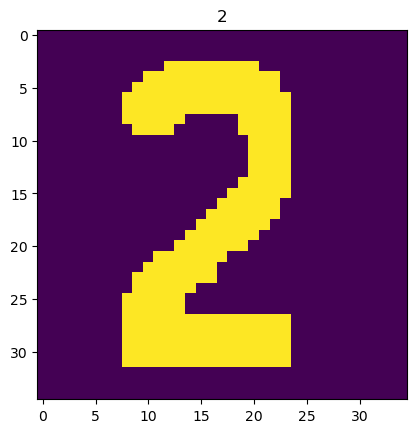

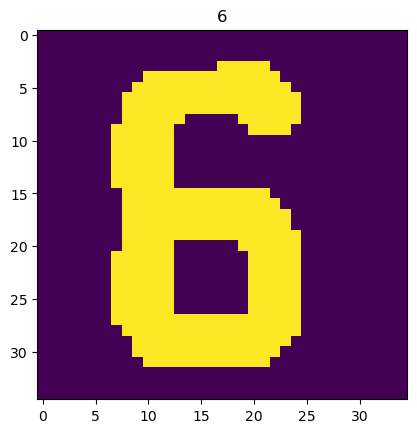

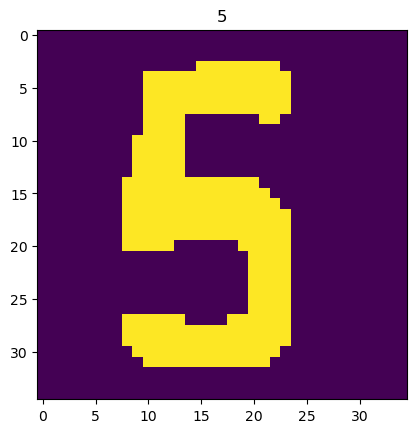

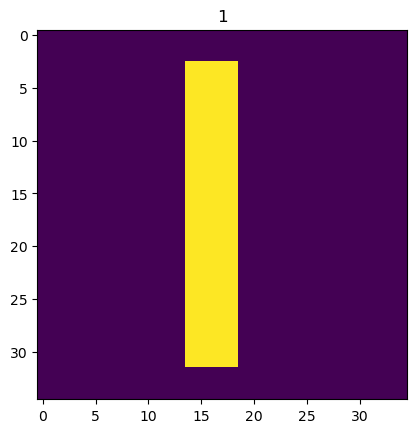

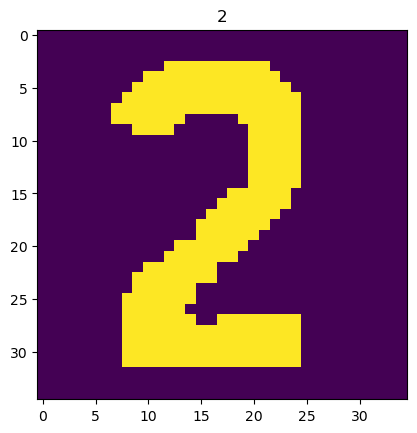

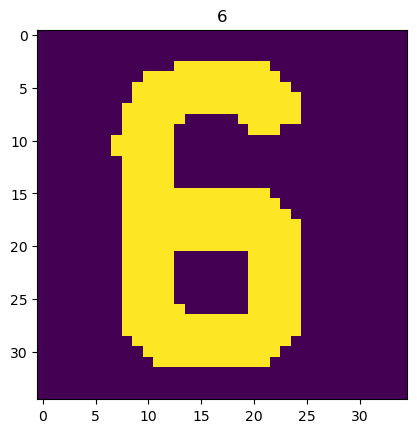

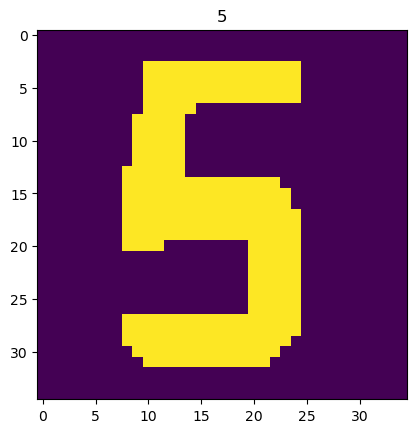

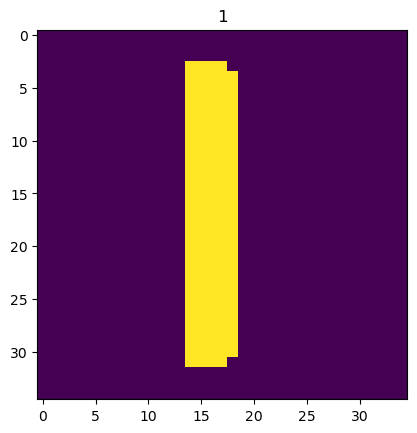

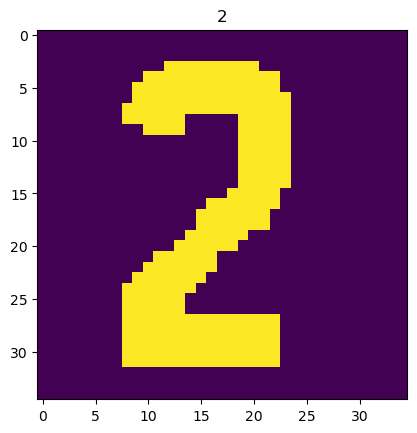

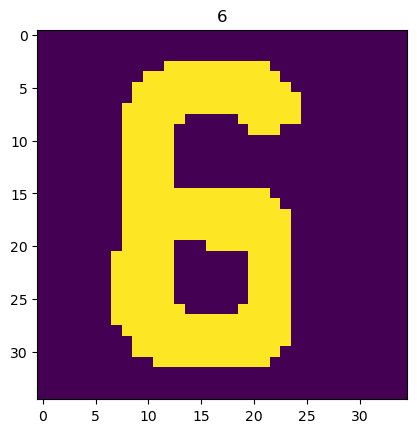

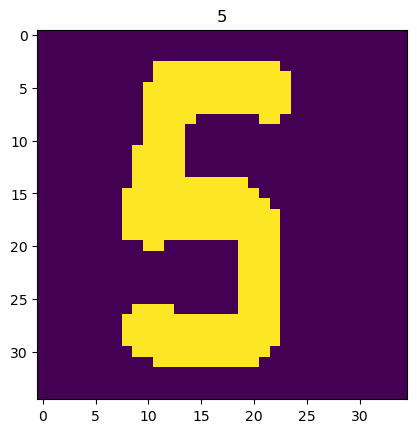

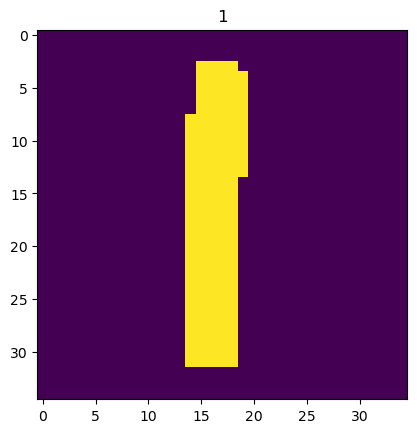

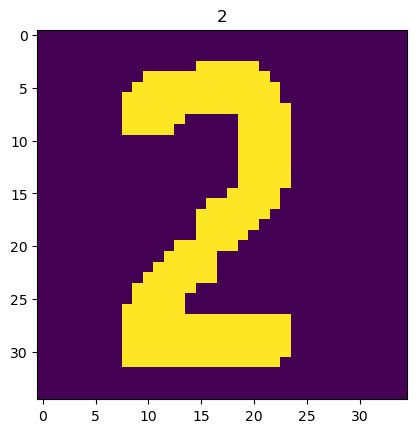

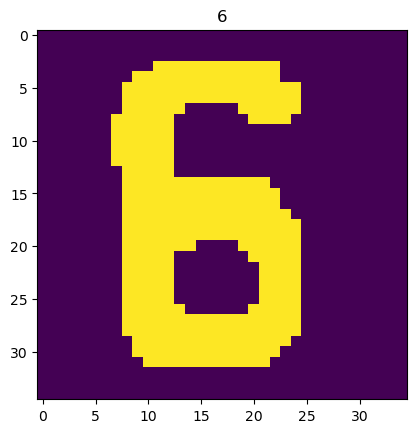

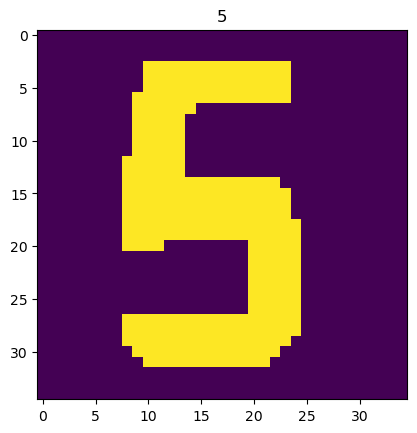

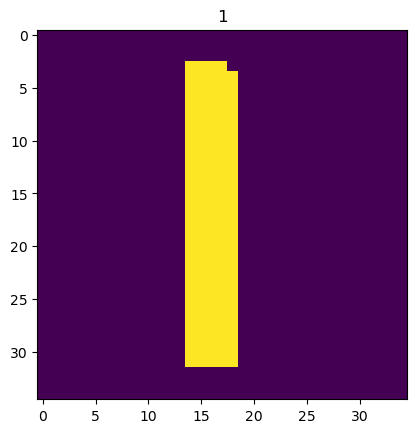

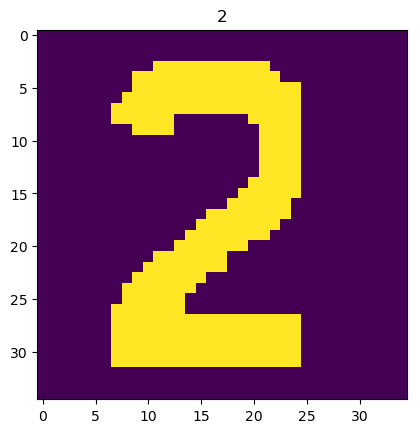

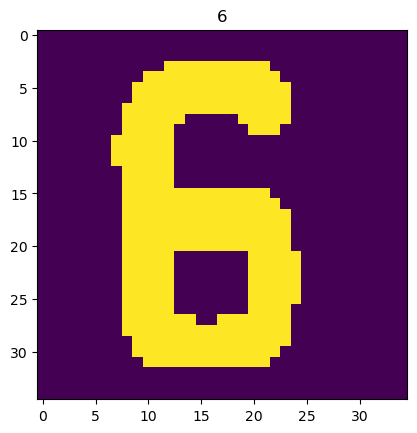

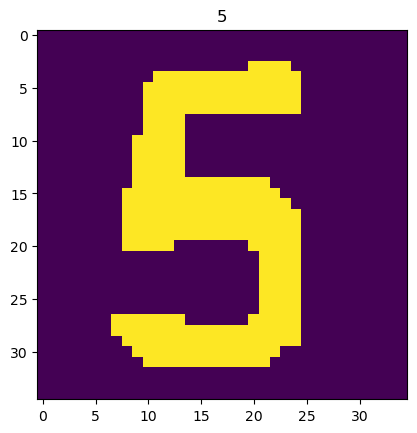

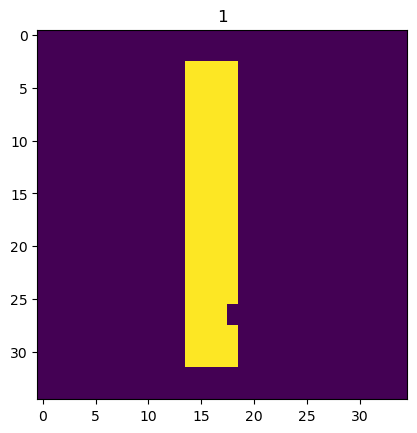

In [3]:

for idx,img_vector in enumerate(ds_imgs[:20,:]):    
    img_data = im.fromarray(np.reshape(img_vector, (35, 35)).astype('uint8')*255)
    fig = plt.figure()
    ax = fig.subplots()
    ax.set_title(ds_labels[idx])
    imgplot = plt.imshow(img_data)



## Feature Extration

### Chain Code

In [61]:
def find_starter_point(img_mat):
    points = list(zip(*np.nonzero(img_mat)))
    y =99999
    x= 99999    
    for point in points:        
        if(point[0]<y):
            y=point[0]
            x= point[1]
    for point in points:
        if(point[1]<x and point[0]==y):
            x= point[1]
    return (x, y)
    

In [144]:
def calc_lines_chain_code(chain_code, min_line_size=3):
    v_lines= list()
    h_lines= list()
    max_v_line= 0
    min_v_line= 0
    max_h_line= 0
    min_h_line= 0
        
    prev_dir=None
    
    current = list()
    for d in chain_code:
        if(prev_dir==d):
            current.append(d)        
       
        if(prev_dir!=d):
            if(len(current)>=min_line_size):
                if(prev_dir==0 or prev_dir==2):
                    h_lines.append(current)
                if(prev_dir==1 or prev_dir==3):
                    v_lines.append(current)
            current =list()
            current.append(d)                    
        prev_dir=d
    if(len(current)>=min_line_size):
        if(prev_dir==0 or prev_dir==2):
            h_lines.append(current)
        if(prev_dir==1 or prev_dir==3):
            v_lines.append(current)    
    
     
    max_v_line = max(map(lambda l: len(l), v_lines)) if len(v_lines)>0 else 0
    min_v_line = min(map(lambda l: len(l), v_lines)) if len(v_lines)>0 else 0
    max_h_line = max(map(lambda l: len(l), h_lines)) if len(h_lines)>0 else 0
    min_h_line = min(map(lambda l: len(l), h_lines)) if len(h_lines)>0 else 0
    return h_lines,max_h_line, min_h_line,v_lines, max_v_line,min_v_line



In [138]:

def chain_code(img_mat):
    start_point =  find_starter_point(img_mat)
    # print("Start point: ", start_point)
    current_point = start_point
    i=0
    last_dir="."
    code = list()
    temp = np.zeros(img_mat.shape)
    chain = list()
    prev=(99999,99999)
    tries=0
    while(True):
        x = current_point[0]
        y=current_point[1]
        
        if(tries>5):   
            # print("Travou em: ", current_point)
            chain.append(start_point)
            break
        
        # print(i," Point: ", current_point," - Direction: ", last_dir)
        if(prev[0]==x and prev[1]==y ):
            tries+=1
            continue
        else:
            tries=0
        
        
        temp[y][x]=1
        chain.append((x,y))
        i+=1        
        
        if(start_point[0]==x and start_point[1]==y and i>1):            
            break                        
                          
        
        if((img_mat[y][x+1]==255 and temp[y][x+1]==0)  or (start_point[0]==x+1 and start_point[1]== y and  i>2)):            
            prev=current_point           
            current_point=(x+1,y)  
            last_dir="R"          
            code.append(0)                    
            continue
        
                        
        if((img_mat[y+1][x]==255 and temp[y+1][x]==0)  or (start_point[0]==x and start_point[1]== y+1 and  i>2)):
            last_dir="B"
            prev=current_point
            current_point=(x,y+1)  
            code.append(3)                     
            continue
        
        if((img_mat[y][x-1]==255 and temp[y][x-1] == 0) or (start_point[0]==x-1 and start_point[1] == y  and  i>2)):            
            prev=current_point
            current_point=(x-1,y)  
            
            last_dir="L"
            code.append(2)                      
            continue        
        
        
        if((img_mat[y-1][x]==255 and temp[y-1][x]==0) or (start_point[0]==x and start_point[1]== y-1 and  i>2)):            
            prev=current_point
            current_point=(x,y-1)              
            last_dir="T"  
            code.append(1)                    
            continue
        
        prev=current_point        
        
    return code, chain
        

### Build Train Dataset

In [267]:
mass_objects =list()
chain_codes =list()
entropies = list()
nd_m_central = list()
count_h_line = list()
max_h_line = list()
min_h_line = list()
count_v_line = list()
max_v_line = list()
min_v_line = list()
images = list()
images_edge = list()

    
    
for idx, img_vector in enumerate(ds_imgs):        
    img_mat= np.reshape(img_vector, (35, 35)).astype('uint8')*255    
    img_data = im.fromarray(img_mat)
    img_data_edges = img_data.filter(FIND_EDGES)            
    edges_mat = np.array(img_data_edges)        
    code, chain = chain_code(edges_mat)    
    r_h_lines,r_max_h_line, r_min_h_line, r_v_lines, r_max_v_line, r_min_v_line = calc_lines_chain_code(code)
    
    entropy = img_data.entropy()        
    obj_mass = (img_mat/255).sum()    
    M10=0
    M01=0
    for r in range(0,35):
        for c in range(0,35):
            M10+= r * (img_mat[r][c]/255)
            M01+= c * (img_mat[r][c]/255)
    
    centroid = (M10/obj_mass, M01/obj_mass)
    
    central_moment=0
    for r in range(0,35):
        for c in range(0,35):
            central_moment+= pow((r - centroid[0]), 2) * (img_mat[r][c]/255)
           
    
    
    images.append(img_data)
    images_edge.append(img_data_edges)
    chain_codes.append(''.join(str(x) for x in code))
    entropies.append(entropy)
    mass_objects.append(obj_mass)
    nd_m_central.append(central_moment)
    
    count_v_line.append(len(r_v_lines)-1)
    max_v_line.append(r_max_v_line)
    min_v_line.append(r_min_v_line)
    
    count_h_line.append(len(r_h_lines)-1)
    max_h_line.append(r_max_h_line)
    min_h_line.append(r_min_h_line)

    # print('IMG LABEL ',ds_labels[idx],' CHAIN CODE: ',''.join(str(x) for x in code) )        
    
    # fig = plt.figure()
    # ax = fig.subplots()
    # ax.set_title(ds_labels[idx])    
    # plt.hlines(y=np.arange(0, 35), xmin=np.full(35, 0), xmax=np.full(35, 35), color="w")
    # plt.vlines(x=np.arange(0, 35), ymin=np.full(35, 0), ymax=np.full(35, 35), color="w")    
    # imgplot = plt.imshow(img_data_edges, extent=(0, 35, 35, 0))        

images_dataset = pd.DataFrame()
images_dataset["label"] = ds_labels
images_dataset["chain_code"] = chain_codes
images_dataset["V_lines"] = count_h_line
images_dataset["MAX_V_line"] = max_v_line
images_dataset["MIN_V_line"] = min_v_line
images_dataset["H_lines"] = count_v_line
images_dataset["MAX_H_line"] = max_h_line
images_dataset["MIN_H_line"] = min_h_line
images_dataset["mass"] = mass_objects
images_dataset["nd_order_central_moment"] = nd_m_central
images_dataset["entropy"] = entropies    
    


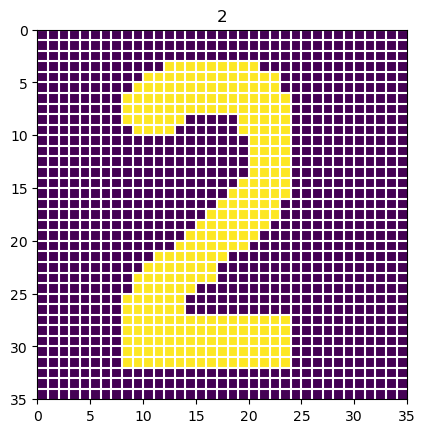

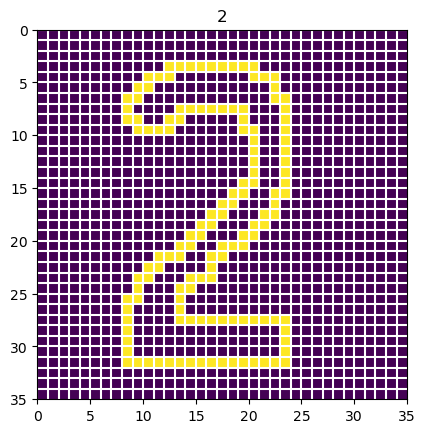

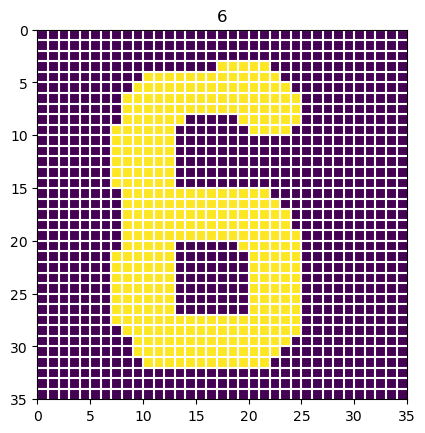

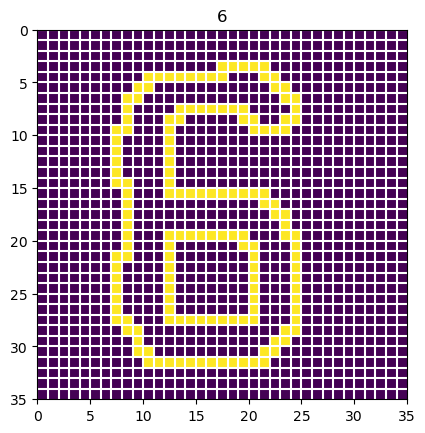

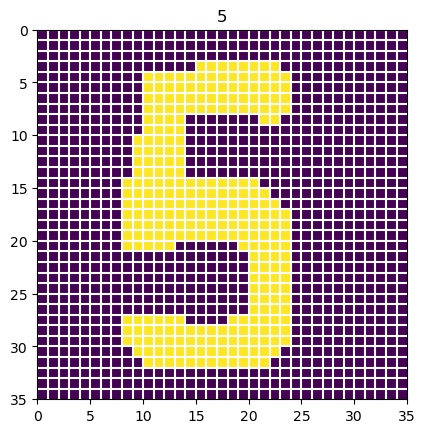

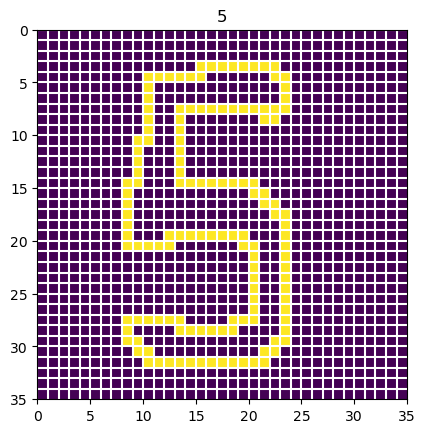

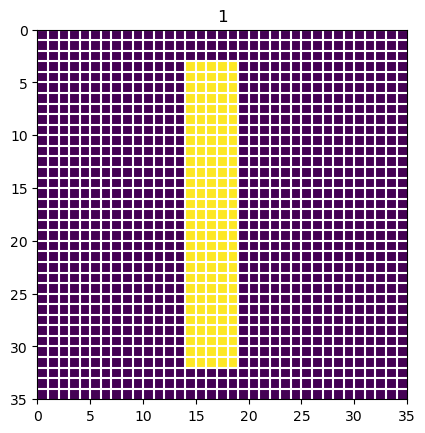

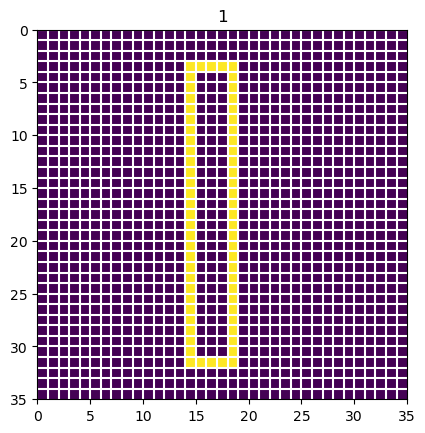

In [268]:
for i in range(0, 4):
    fig = plt.figure()
    ax = fig.subplots()
    ax.set_title(ds_labels[i])    
    plt.hlines(y=np.arange(0, 35), xmin=np.full(35, 0), xmax=np.full(35, 35), color="w")
    plt.vlines(x=np.arange(0, 35), ymin=np.full(35, 0), ymax=np.full(35, 35), color="w")    
    imgplot = plt.imshow(images[i], extent=(0, 35, 35, 0))      
    fig = plt.figure()
    ax = fig.subplots()
    ax.set_title(ds_labels[i])    
    plt.hlines(y=np.arange(0, 35), xmin=np.full(35, 0), xmax=np.full(35, 35), color="w")
    plt.vlines(x=np.arange(0, 35), ymin=np.full(35, 0), ymax=np.full(35, 35), color="w")    
    imgplot = plt.imshow(images_edge[i], extent=(0, 35, 35, 0))      

# PREPARAÇÃO

In [150]:
images_dataset.head(10)


,label,chain_code,V_lines,MAX_V_line,MIN_V_line,H_lines,MAX_H_line,MIN_H_line,mass,nd_order_central_moment,entropy
0,2,0000000030033033333333323323232322323322323330...,4,9,3,4,15,3,269.0,24973.561338,0.759422
1,6,0000303030332322212122222232333333300000000030...,5,9,3,5,11,3,350.0,25304.560000,0.863121
2,5,0000000303332321222222223333333000000030303033...,8,12,3,6,11,4,288.0,22010.986111,0.786800
3,1,0000333333333333333333333333333322221111111111...,1,28,28,1,4,4,145.0,10150.000000,0.524650
4,2,0000000003030303333333323323232323232233223323...,5,8,4,3,16,3,284.0,26570.239437,0.781199
5,6,0000000030303033223221212222223233333330000000...,4,17,3,3,10,3,347.0,25270.224784,0.859862
6,5,0000000000000033322222222223233333330000000003...,6,11,3,6,14,3,309.0,23815.288026,0.814817
7,1,0003033333333333333333333333333232221111111111...,1,28,26,1,3,3,143.0,9758.000000,0.519901
8,2,0000000030033033333333233233223232233232323330...,4,8,3,4,14,3,264.0,24302.666667,0.751884
9,6,0000000003030303322322121222222323333333000000...,3,14,6,3,10,6,341.0,25472.862170,0.853217


In [183]:
prepared_data = images_dataset.copy()
headers = list(images_dataset.columns.values.tolist())
cols_to_norm = filter(lambda x: x != 'label' and x!= "chain_code", headers)

for col in cols_to_norm:
    prepared_data[col] = prepared_data[col]  / prepared_data[col].abs().max()
    prepared_data[col]=prepared_data[col].astype("float32")

prepared_data.pop("chain_code")
prepared_data.head(10)


,label,V_lines,MAX_V_line,MIN_V_line,H_lines,MAX_H_line,MIN_H_line,mass,nd_order_central_moment,entropy
0,2,0.363636,0.321429,0.107143,0.285714,0.681818,0.250000,0.615561,0.797424,0.807947
1,6,0.454545,0.321429,0.107143,0.357143,0.500000,0.250000,0.800915,0.807993,0.918273
2,5,0.727273,0.428571,0.107143,0.428571,0.500000,0.333333,0.659039,0.702827,0.837075
3,1,0.090909,1.000000,1.000000,0.071429,0.181818,0.333333,0.331808,0.324097,0.558174
4,2,0.454545,0.285714,0.142857,0.214286,0.727273,0.250000,0.649886,0.848408,0.831117
5,6,0.363636,0.607143,0.107143,0.214286,0.454545,0.250000,0.794050,0.806897,0.914806
6,5,0.545455,0.392857,0.107143,0.428571,0.636364,0.250000,0.707094,0.760440,0.866882
7,1,0.090909,1.000000,0.928571,0.071429,0.136364,0.250000,0.327231,0.311580,0.553122
8,2,0.363636,0.285714,0.107143,0.285714,0.636364,0.250000,0.604119,0.776002,0.799928
9,6,0.272727,0.500000,0.214286,0.214286,0.454545,0.500000,0.780320,0.813367,0.907736


In [184]:
X_train, X_test, y_train, y_test = train_test_split(prepared_data.iloc[:, :], prepared_data.iloc[:,0:1], test_size=0.20,stratify= prepared_data.iloc[:,0:1], random_state=random_state)


In [185]:

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671 entries, 937 to 1930
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    671 non-null    int64  
 1   V_lines                  671 non-null    float32
 2   MAX_V_line               671 non-null    float32
 3   MIN_V_line               671 non-null    float32
 4   H_lines                  671 non-null    float32
 5   MAX_H_line               671 non-null    float32
 6   MIN_H_line               671 non-null    float32
 7   mass                     671 non-null    float32
 8   nd_order_central_moment  671 non-null    float32
 9   entropy                  671 non-null    float32
dtypes: float32(9), int64(1)
memory usage: 34.1 KB


# Classificação

In [193]:
def custom_plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, KFold

### K-Fold

In [243]:
# from sklearn.model_selection import cross_validate,cross_val_predict
def run_kfold(k_x, k_y, model, k=10):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)    
    conf_matrix_k = list()
    accuracy_k = list()
    precision_k = list()
    recall_k = list()
    f1_k = list()

    for k, (train_index, test_index) in enumerate(skf.split(k_x, k_y)):    
        k_X_train, k_X_test = k_x.iloc[train_index], k_x.iloc[test_index]
        k_y_train, k_y_test = k_y.iloc[train_index], k_y.iloc[test_index]

        model.fit(k_X_train, k_y_train.values.ravel())    
        predictions = model.predict(k_X_test) 
        accuracy = metrics.accuracy_score(k_y_test.values, np.array(predictions))
        f1 = metrics.f1_score(k_y_test.values, np.array(predictions), average="macro")
        recall = metrics.recall_score(k_y_test.values, np.array(predictions), average="macro")
        precision = metrics.precision_score(k_y_test.values, np.array(predictions), average="macro")
        cf_m= confusion_matrix(k_y_test.values, np.array(predictions),labels=[0,1,2,3,4,5,6,7,8,9])
        accuracy_k.append(accuracy)
        precision_k.append(precision)
        recall_k.append(recall)
        f1_k.append(f1)
        conf_matrix_k.append(cf_m)
    
    return np.mean(accuracy_k), np.std(accuracy_k), np.mean(precision_k), np.std(precision_k), np.mean(recall_k) ,np.std(recall_k), np.mean(f1_k), np.std(f1_k), np.mean(conf_matrix_k, axis=0)

def plot_kfold_result(accuracy_mean, accuracy_std, precision_mean, precision_std, recall_mean, recall_std, f1_mean, f1_std, conf_matrix_mean):
    print("Accuracy Media", accuracy_mean)
    print("Accuracy STD", accuracy_std)
    print("Precision Media", precision_mean)
    print("Precision STD", precision_std)
    print("Recall Media", recall_mean)
    print("Recall STD", recall_std)
    print("F1 Media", f1_mean)
    print("F1 STD", f1_std)
    print("Matriz de Conf. Media")
    print(conf_matrix_mean)
    custom_plot_confusion_matrix(conf_matrix_mean,target_names= [0,1,2,3,4,5,6,7,8,9])

## Random Forest

#### 1 run

ACC:  0.9985096870342772


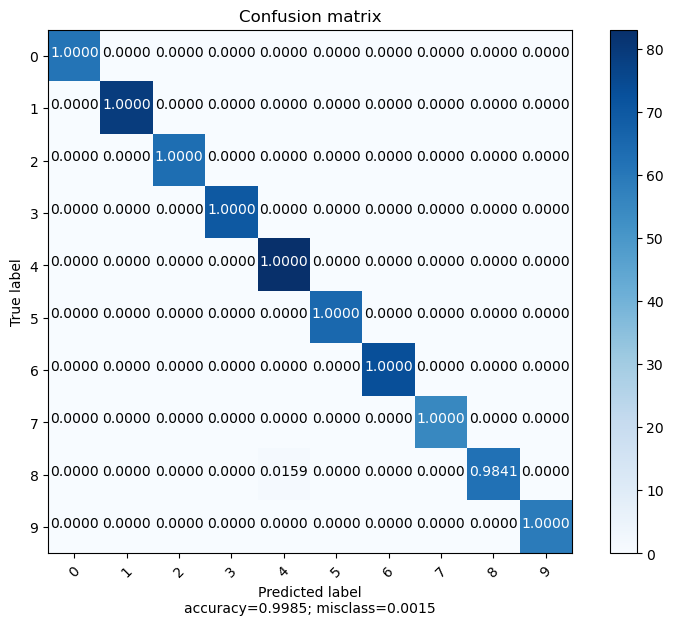

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        79
           2       1.00      1.00      1.00        63
           3       1.00      1.00      1.00        70
           4       0.99      1.00      0.99        83
           5       1.00      1.00      1.00        65
           6       1.00      1.00      1.00        73
           7       1.00      1.00      1.00        55
           8       1.00      0.98      0.99        63
           9       1.00      1.00      1.00        59

    accuracy                           1.00       671
   macro avg       1.00      1.00      1.00       671
weighted avg       1.00      1.00      1.00       671



In [239]:


model = RandomForestClassifier(n_estimators=20, random_state=random_state)


model.fit(X_train, y_train.values.ravel())
predictions = model.predict(X_test) 

accuracy = metrics.accuracy_score(y_test.values, np.array(predictions))
print("ACC: ", accuracy)

cf_m= confusion_matrix(y_test.values, np.array(predictions),labels=[0,1,2,3,4,5,6,7,8,9])
# print(cf_m)
custom_plot_confusion_matrix(cf_m,target_names= [0,1,2,3,4,5,6,7,8,9])
print(classification_report(y_test.values,predictions))







### Run k-fold 10

#### Features:  
 
 + 1   V_lines                  671 non-null    float32
 + 2   MAX_V_line               671 non-null    float32
 + 3   MIN_V_line               671 non-null    float32
 + 4   H_lines                  671 non-null    float32
 + 5   MAX_H_line               671 non-null    float32
 + 6   MIN_H_line

Accuracy Media 0.8562100213219617
Accuracy STD 0.016713990457317123
Precision Media 0.8573950519265081
Precision STD 0.018213687473860506
Recall Media 0.8537716698722406
Recall STD 0.016787804545457672
F1 Media 0.8539605514403876
F1 STD 0.01746443024898714
Matriz de Conf. Media
[[29.2  0.   0.   0.   0.8  0.   0.4  0.   0.4  0. ]
 [ 0.  39.7  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  28.   1.8  0.2  0.6  0.5  0.1  0.   0.1]
 [ 0.   0.1  1.8 27.2  0.1  5.1  0.2  0.1  0.   0.2]
 [ 0.3  0.   0.3  0.  38.3  0.   1.   1.   0.3  0.1]
 [ 0.   0.   0.8  6.3  0.  25.1  0.2  0.   0.   0.2]
 [ 0.1  0.   0.5  0.6  1.   0.  25.1  0.   0.   9. ]
 [ 0.   0.   0.3  0.1  1.3  0.   0.  25.5  0.2  0. ]
 [ 0.2  0.   0.1  0.   0.5  0.   0.1  0.4 30.   0. ]
 [ 0.2  0.   0.8  0.1  0.3  0.2  9.2  0.   0.  18.9]]


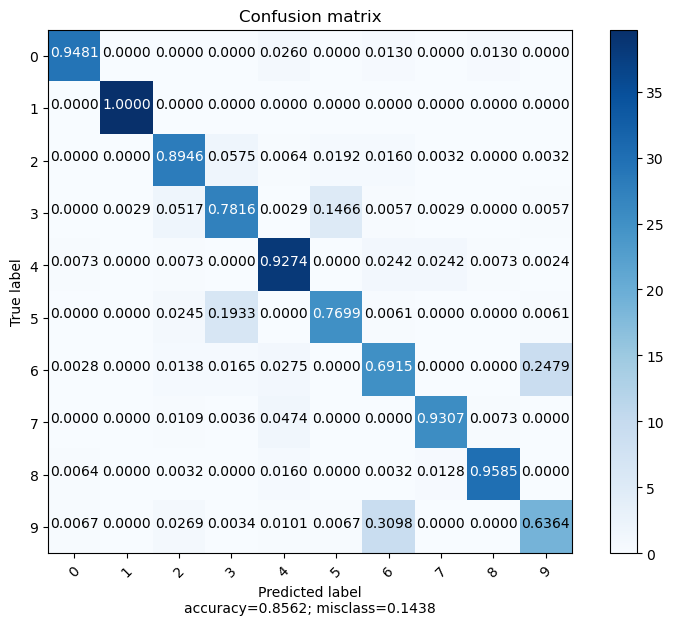

In [258]:
k_y = prepared_data.iloc[:,0:1]
k_x = prepared_data.iloc[:, 1:7]
model = RandomForestClassifier(n_estimators=20, random_state=random_state)
accuracy_mean, accuracy_std, precision_mean, precision_std, recall_mean, recall_std, f1_mean, f1_std, conf_matrix_mean = run_kfold(k_x,k_y, model)
plot_kfold_result(accuracy_mean, accuracy_std, precision_mean, precision_std, recall_mean, recall_std, f1_mean, f1_std, conf_matrix_mean)

#### Features:
+ `mass`; e
+ `nd_order_central_moment`

Accuracy Media 0.7264187988628287
Accuracy STD 0.025104787029216168
Precision Media 0.7161707045031541
Precision STD 0.02620165993333009
Recall Media 0.715668762877189
Recall STD 0.02526237456198387
F1 Media 0.7132428633243351
F1 STD 0.0259326326408763
Matriz de Conf. Media
[[19.2  0.   0.   0.8  0.   3.7  2.7  0.1  1.9  2.4]
 [ 0.  39.7  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.1  0.  22.3  8.9  0.   0.   0.   0.   0.   0. ]
 [ 0.7  0.1  9.9 23.7  0.   0.3  0.   0.1  0.   0. ]
 [ 0.1  0.   0.   0.  41.1  0.   0.   0.   0.1  0. ]
 [ 3.4  0.   0.   0.1  0.  26.9  0.6  0.   0.   1.6]
 [ 2.2  0.   0.   0.   0.   0.5 16.9  0.   7.6  9.1]
 [ 0.1  0.1  0.   0.   0.   0.   0.  27.2  0.   0. ]
 [ 1.9  0.   0.   0.   0.1  0.   6.9  0.  17.9  4.5]
 [ 2.7  0.   0.   0.1  0.   2.7 10.   0.   5.6  8.6]]


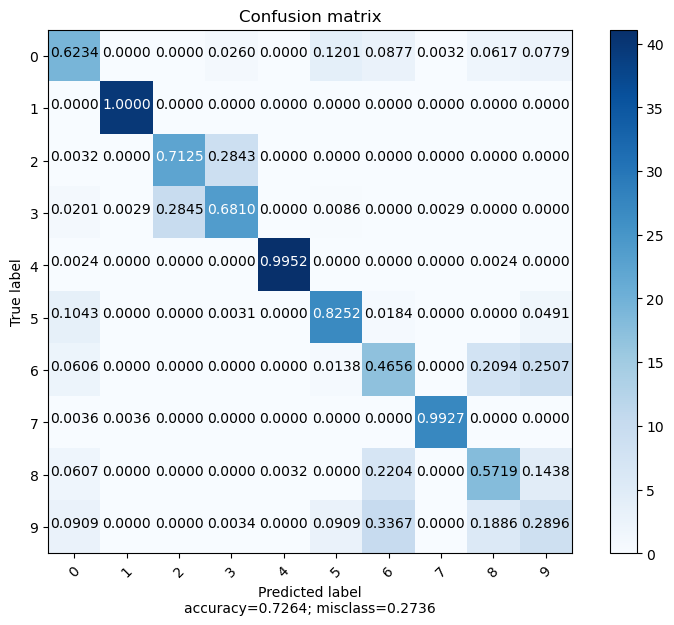

In [250]:
k_y = prepared_data.iloc[:,0:1]
k_x = prepared_data.iloc[:, 7:9]
model = RandomForestClassifier(n_estimators=20, random_state=random_state)
accuracy_mean, accuracy_std, precision_mean, precision_std, recall_mean, recall_std, f1_mean, f1_std, conf_matrix_mean = run_kfold(k_x,k_y, model)
plot_kfold_result(accuracy_mean, accuracy_std, precision_mean, precision_std, recall_mean, recall_std, f1_mean, f1_std, conf_matrix_mean)

#### All Features

Accuracy Media 0.9325817341862118
Accuracy STD 0.013069128706591656
Precision Media 0.9326135403297053
Precision STD 0.013643646938837583
Recall Media 0.9295701300146926
Recall STD 0.013727821643558557
F1 Media 0.9297622468695718
F1 STD 0.013876204085052411
Matriz de Conf. Media
[[29.9  0.   0.   0.   0.   0.   0.3  0.   0.3  0.3]
 [ 0.  39.7  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  29.2  1.9  0.   0.2  0.   0.   0.   0. ]
 [ 0.   0.1  1.5 33.   0.   0.1  0.   0.1  0.   0. ]
 [ 0.1  0.   0.   0.  41.1  0.   0.   0.   0.1  0. ]
 [ 0.   0.   0.   0.2  0.  32.4  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  29.9  0.   0.   6.4]
 [ 0.   0.   0.   0.   0.   0.1  0.  27.3  0.   0. ]
 [ 0.1  0.   0.   0.   0.1  0.   0.   0.  31.   0.1]
 [ 0.1  0.   0.2  0.   0.   0.2 10.1  0.   0.  19.1]]


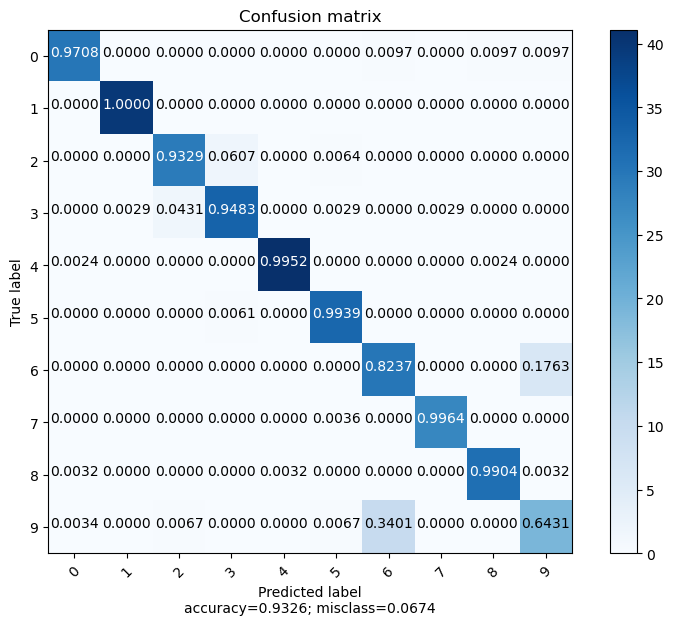

In [244]:
k_y = prepared_data.iloc[:,0:1]
k_x = prepared_data.iloc[:, 1:]
model = RandomForestClassifier(n_estimators=20, random_state=random_state)
accuracy_mean, accuracy_std, precision_mean, precision_std, recall_mean, recall_std, f1_mean, f1_std, conf_matrix_mean = run_kfold(k_x,k_y, model)
plot_kfold_result(accuracy_mean, accuracy_std, precision_mean, precision_std, recall_mean, recall_std, f1_mean, f1_std, conf_matrix_mean)


# MLP

### 1 run

ACC:  0.9985096870342772


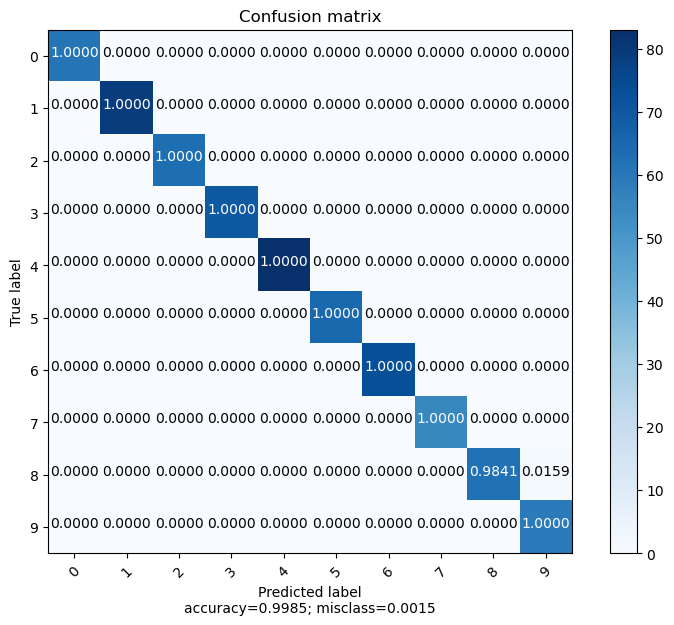

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        79
           2       1.00      1.00      1.00        63
           3       1.00      1.00      1.00        70
           4       1.00      1.00      1.00        83
           5       1.00      1.00      1.00        65
           6       1.00      1.00      1.00        73
           7       1.00      1.00      1.00        55
           8       1.00      0.98      0.99        63
           9       0.98      1.00      0.99        59

    accuracy                           1.00       671
   macro avg       1.00      1.00      1.00       671
weighted avg       1.00      1.00      1.00       671



In [261]:
from sklearn.neural_network import MLPClassifier


model = MLPClassifier(random_state=random_state, max_iter=500)

model.fit(X_train, y_train.values.ravel())
predictions = model.predict(X_test) 

accuracy = metrics.accuracy_score(y_test.values, np.array(predictions))
print("ACC: ", accuracy)

cf_m= confusion_matrix(y_test.values, np.array(predictions),labels=[0,1,2,3,4,5,6,7,8,9])
# print(cf_m)
custom_plot_confusion_matrix(cf_m,target_names= [0,1,2,3,4,5,6,7,8,9])
print(classification_report(y_test.values,predictions))







### Run k-fold 10

#### Features:  
 
 + 1   V_lines                  671 non-null    float32
 + 2   MAX_V_line               671 non-null    float32
 + 3   MIN_V_line               671 non-null    float32
 + 4   H_lines                  671 non-null    float32
 + 5   MAX_H_line               671 non-null    float32
 + 6   MIN_H_line

Accuracy Media 0.8433715351812365
Accuracy STD 0.015046134451143457
Precision Media 0.8445691067459627
Precision STD 0.015294052136146421
Recall Media 0.8413808090974275
Recall STD 0.014562419448927664
F1 Media 0.8407072779964745
F1 STD 0.015501696233773055
Matriz de Conf. Media
[[29.6  0.   0.   0.   0.8  0.   0.1  0.   0.3  0. ]
 [ 0.  39.6  0.   0.   0.   0.   0.   0.   0.1  0. ]
 [ 0.   0.  28.   2.4  0.   0.2  0.4  0.3  0.   0. ]
 [ 0.   0.1  1.  28.1  0.3  5.2  0.   0.   0.   0.1]
 [ 0.3  0.1  0.   0.1 37.3  0.   1.3  1.5  0.7  0. ]
 [ 0.   0.   0.4  7.4  0.  24.5  0.1  0.   0.   0.2]
 [ 0.2  0.   1.   0.7  1.9  0.1 23.2  0.   0.   9.2]
 [ 0.   0.   0.3  0.   1.1  0.   0.  25.7  0.3  0. ]
 [ 0.3  0.   0.   0.   0.8  0.   0.   0.5 29.7  0. ]
 [ 0.2  0.   0.6  0.2  0.6  0.5 10.6  0.   0.  17. ]]


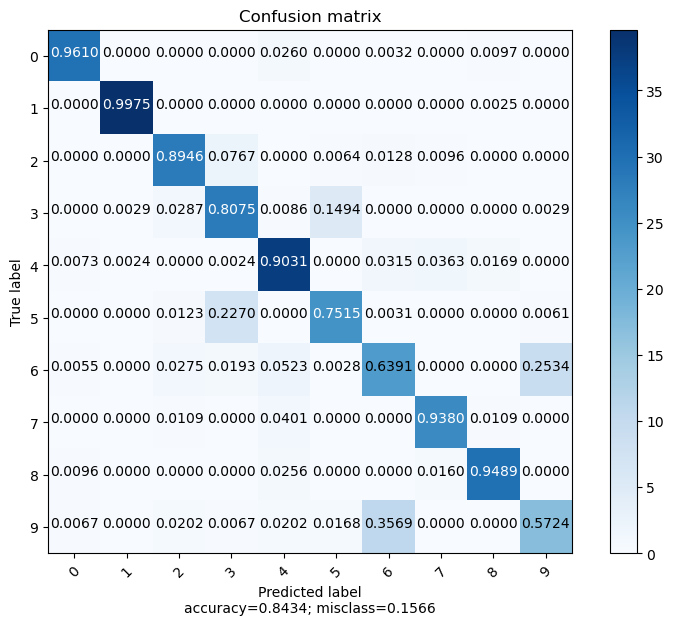

In [264]:
k_y = prepared_data.iloc[:,0:1]
k_x = prepared_data.iloc[:, 1:7]
model = MLPClassifier(random_state=random_state, max_iter=1000)
accuracy_mean, accuracy_std, precision_mean, precision_std, recall_mean, recall_std, f1_mean, f1_std, conf_matrix_mean = run_kfold(k_x,k_y, model)
plot_kfold_result(accuracy_mean, accuracy_std, precision_mean, precision_std, recall_mean, recall_std, f1_mean, f1_std, conf_matrix_mean)

#### Features:
+ `mass`; e
+ `nd_order_central_moment`

Accuracy Media 0.7371775053304903
Accuracy STD 0.02211400129814291
Precision Media 0.7231031205093824
Precision STD 0.035671605611173586
Recall Media 0.7242629115562164
Recall STD 0.022674214079105904
F1 Media 0.7112515767204887
F1 STD 0.02400004542678675
Matriz de Conf. Media
[[21.8  0.   0.1  0.5  0.   3.1  3.8  0.   1.   0.5]
 [ 0.  39.6  0.   0.   0.   0.   0.   0.1  0.   0. ]
 [ 0.3  0.  21.3  9.7  0.   0.   0.   0.   0.   0. ]
 [ 0.5  0.1  8.2 25.7  0.   0.2  0.   0.1  0.   0. ]
 [ 0.1  0.   0.   0.  41.2  0.   0.   0.   0.   0. ]
 [ 3.8  0.   0.   0.1  0.  28.3  0.1  0.   0.   0.3]
 [ 2.3  0.   0.   0.   0.   0.9 19.7  0.   9.2  4.2]
 [ 0.   0.2  0.   0.   0.   0.1  0.  27.1  0.   0. ]
 [ 1.6  0.   0.   0.   0.1  0.1 10.   0.  19.2  0.3]
 [ 3.2  0.   0.   0.1  0.   3.7 12.7  0.   6.8  3.2]]


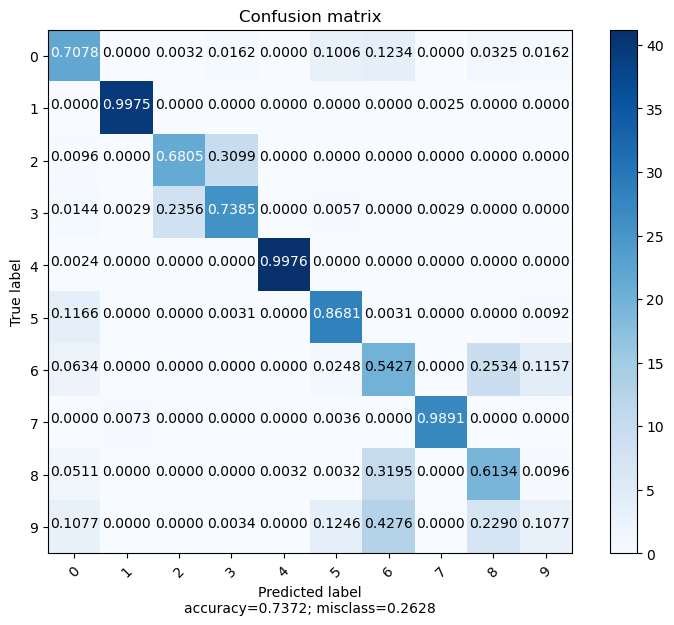

In [265]:
k_y = prepared_data.iloc[:,0:1]
k_x = prepared_data.iloc[:, 7:9]
model = MLPClassifier(random_state=random_state, max_iter=1000)
accuracy_mean, accuracy_std, precision_mean, precision_std, recall_mean, recall_std, f1_mean, f1_std, conf_matrix_mean = run_kfold(k_x,k_y, model)
plot_kfold_result(accuracy_mean, accuracy_std, precision_mean, precision_std, recall_mean, recall_std, f1_mean, f1_std, conf_matrix_mean)

#### All Features


Accuracy Media 0.9167626154939587
Accuracy STD 0.009959037645518694
Precision Media 0.9158189117863056
Precision STD 0.011346107023035106
Recall Media 0.9134299179497031
Recall STD 0.009885213682395616
F1 Media 0.9130492431998292
F1 STD 0.010167876543195242
Matriz de Conf. Media
[[30.3  0.   0.   0.   0.   0.   0.1  0.   0.4  0. ]
 [ 0.  39.7  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  28.6  2.7  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.1  1.3 33.4  0.   0.   0.   0.   0.   0. ]
 [ 0.1  0.   0.   0.  41.1  0.   0.   0.   0.1  0. ]
 [ 0.   0.   0.1  0.1  0.  32.4  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.2 26.7  0.   0.   9.4]
 [ 0.   0.   0.1  0.   0.   0.   0.  27.3  0.   0. ]
 [ 0.2  0.   0.   0.   0.1  0.   0.   0.  31.   0. ]
 [ 0.   0.   0.   0.   0.1  0.5 12.3  0.   0.  16.8]]


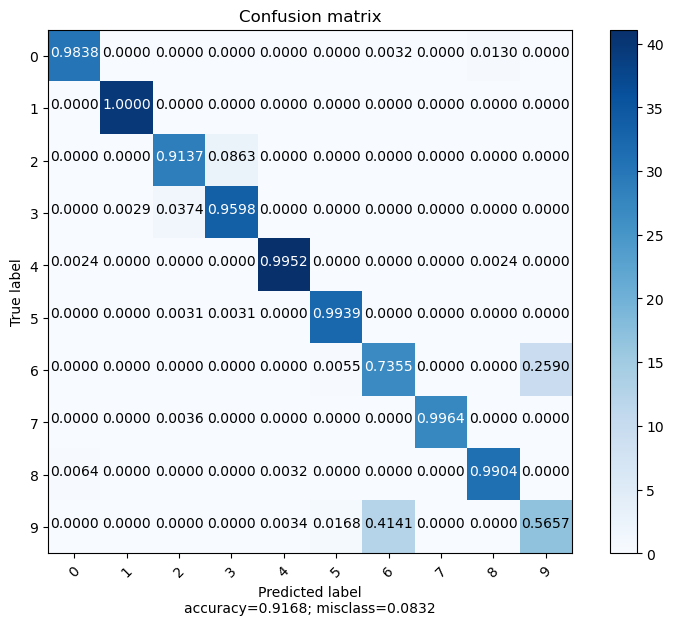

In [266]:
k_y = prepared_data.iloc[:,0:1]
k_x = prepared_data.iloc[:, 1:]
model = MLPClassifier(random_state=random_state, max_iter=1000)
accuracy_mean, accuracy_std, precision_mean, precision_std, recall_mean, recall_std, f1_mean, f1_std, conf_matrix_mean = run_kfold(k_x,k_y, model)
plot_kfold_result(accuracy_mean, accuracy_std, precision_mean, precision_std, recall_mean, recall_std, f1_mean, f1_std, conf_matrix_mean)